In [1]:
import numpy as np
import numba
import matplotlib.pyplot as plt

@numba.jit(nopython=True)
def simulate_polulation_agents(Bstate, Pstate, Istate, LORstate, \
                               record_time_step, final_time,  bacteria, phage,infected, bacteriaever, carrying_capacity, \
                               growth_rate, lysis_rate, burst_rate, eclipse, growth_timer, lysis_timer, eta, lysis_inhibition=False, lysis_inhibition_timer=5, \
                               lysis_from_without=False, lysis_from_without_phage=10, lo_resistance=False, lo_resistance_time=5, li_collapse=False, li_collapse_phage=100):
                    
    """
    Simulates a population dynamics with individulal bacteria has growth timer and lysis timer. 
    Simulate V ml. The number of phages (integer)

    Parameters:
    - time_step: The time step for evaluating the dynamics.
    -record_time_step: The time step for recording the dynamics.
    - final_time: The final time to simulate.
    - bacteria: The initial number of bacteria.
    - infected: The initial number of infected bacteria.
    - phage: The initial number of phage.
    - carrying_capacity: The carrying capacity of the environment. 
    system volume is calulcated from this assuming 1ml has carrying capacity of 10^9 cells. 
    - growth_rate: The growth rate of the bacteria.
    - lysis_rate: 1/The latency time of the phage production.
    - burst_rate The burst rate of the phage.
    - ecliplse: The ecliplse time of the phage.
    - growth_timer: Number of the growth timer of the bacteria.
    - lysis_timer: Number of the lysis timer of upon infection.
    - eta: The adsorption rate of the phage.
    - lysis_inhibition: Whether the lysis inhibition is present. Default is False.
    
    Returns:
    - time: A list of times.
    - Btimeseries: A list of the number of bacteria at each record time step.
    - Itimeseries: A list of the number of infected bacteria at each record time step.
    - Ptimeseries: A list of the number of phage at each record time step.
    """

    volume=carrying_capacity/1e9 # volume in ml
    timenow = 0
    nrecord=int(final_time/record_time_step)
    time = np.zeros(nrecord)
    Btimeseries = np.zeros(nrecord)
    Itimeseries = np.zeros(nrecord)
    Ptimeseries = np.zeros(nrecord)
    irecord=0
    time[irecord]=timenow
    Btimeseries[irecord]=bacteria
    Itimeseries[irecord]=infected
    Ptimeseries[irecord]=phage
    grate= growth_rate*growth_timer
    lrate=lysis_rate*lysis_timer
    print(volume)

    
    
    while timenow < final_time: 
        infectionrate=bacteria*eta*phage/volume
        Totalrate=infectionrate+(bacteria-infected)*grate+infected*lrate
        if(Totalrate==0):
            print("Extinction")
            break
        tau = np.random.exponential(1/Totalrate)
        
        if(timenow+tau>time[irecord]+record_time_step):
            irecord+=1
            time[irecord]=time[irecord-1]+record_time_step
            Btimeseries[irecord]=bacteria
            Itimeseries[irecord]=infected
            Ptimeseries[irecord]=phage
            print(irecord, time[irecord], Btimeseries[irecord], Itimeseries[irecord], Ptimeseries[irecord])

        timenow+=tau
        #recording the time spent in infected state
        mask = Bstate > growth_timer
        Pstate[mask] += tau
        
        event = np.random.rand()
        if event < infectionrate/Totalrate:
            phage-=1
            notinfect=True
            while notinfect:
                j=np.random.randint(0,bacteriaever)
                if(Bstate[j]>0):
                    Istate[j]+=1
                    if(lo_resistance):
                        if not LORstate[j] and Pstate[j] > lo_resistance_time:
                            # Code to execute when LORstate[j] is False and Pstate[j] > lo_resistance_time
                            LORstate[j]=True
                    if(Bstate[j]<=growth_timer):
                        infected+=1
                        Bstate[j]=growth_timer+1
                    else:
                        if not LORstate[j] and lysis_from_without :
                            if(Istate[j]>lysis_from_without_phage):    
                                Bstate[j]=0
                                infected-=1
                                bacteria-=1
                                print("Lysis from without")
                                phage+=max(int(burst_rate*(Pstate[j]-eclipse)),0)
                        if LORstate[j] or not lysis_from_without:
                            if lysis_inhibition:
                                    Bstate[j]=max(growth_timer+1, Bstate[j]-lysis_inhibition_timer)
                            if li_collapse and Istate[j]>li_collapse_phage:
                                    Bstate[j]=0
                                    infected-=1
                                    bacteria-=1
                                    phage+=max(int(burst_rate*(Pstate[j]-eclipse)),0)
                                    print("Lysis inhibition collapse")
                    notinfect=False
        elif event < (infectionrate+(bacteria-infected)*grate)/Totalrate:
            notgrown=True
            while notgrown:
                j=np.random.randint(0,bacteriaever)
                if(Bstate[j] > 0 and Bstate[j]<=growth_timer): 
                    if(Bstate[j]<growth_timer):
                        Bstate[j]+=1
                    else:
                        Bstate[j]=1
                        bacteria+=1
                        bacteriaever+=1
                        print("Growth")
                        if(bacteriaever<carrying_capacity):
                            Bstate[bacteriaever-1]=1
                        else:
                            print("Carrying capacity reached")
                            timenow=final_time
                            break
                    notgrown=False
        else:
            notlysed=True
            while notlysed:
                j=np.random.randint(0,bacteriaever)
                if(Bstate[j]>growth_timer and Bstate[j]<=growth_timer+lysis_timer):
                    if(Bstate[j]<growth_timer+lysis_timer):
                        Bstate[j]+=1
                    else:
                        Bstate[j]=0
                        infected-=1
                        bacteria-=1
                        print("Lysis from within", eclipse, Pstate[j])
                        phage+=max(int(burst_rate*(Pstate[j]-eclipse)),0)
                    notlysed=False  
    return time, Btimeseries, Itimeseries, Ptimeseries, irecord

In [2]:
#Here we define the system parameters.
#We start with the simulation done in the Julia's thesis of different MSOI
growth_rate = 0 #per minute
lysis_rate = 1/23  #per minute
growth_timer = 10 #max growth timer
lysis_timer = 23 #max lysis timer
eclipse = 15    #eclipse time in minutes
burst_size = 100 #burst size
burst_rate=burst_size/(1/lysis_rate-eclipse)
eta = 5e-9  #adsorption rate per ml/min
lysis_inhibition=True
lysis_inhibition_timer=5
lysis_from_without=False
lysis_from_without_phage=10
lo_resistance=False
lo_resistance_time=5
li_collapse=False
li_collapse_phage=80

: 

In [3]:
#Now set the initial condition and run the simulation. 
record_time_step = 1 #minutes

factor=0.001
carrying_capacity = int(1e9*factor) #max cells
bacteria = int(1e4) #cells
infected=int(1e4)
si_duration=3 #minutes
msoi=0.4 #=P_0(1-exp(-eta*B*si_duration))/(eta*B^2)
P0=msoi*(eta*((bacteria+infected)/factor)**2)/(1-np.exp(-eta*float(bacteria+infected)/factor*si_duration))
phage = int(P0*factor) #pfu
si_time=15 #minutes
final_time = si_time #minutes

Bstate = np.zeros(carrying_capacity) # 1 to growth_timer is uninfected, growth_timer+1 to growth_timer+lysis_timer is infected
    # assign a random integer number between 1 and growth_timer to each bacteria
Pstate = np.zeros(carrying_capacity) # recording time spent in infected state, to compute number of produced phages for an infected bacteria, proportional to time spent in infected state (minus ecliplse)
Istate = np.zeros(carrying_capacity) # Count the number of infection in total
LORstate = np.zeros(carrying_capacity, np.bool_) # boolian, True if it is in Lysis from without resistant state
Bstate[:bacteria] = np.random.randint(1, growth_timer+1, size=bacteria)
Bstate[bacteria:bacteria+infected] = growth_timer+1
bacteriaever=bacteria+infected

time, Btimeseries, Itimeseries, Ptimeseries, irecord = simulate_polulation_agents(Bstate, Pstate, Istate, LORstate, record_time_step, final_time,  \
                                bacteria, phage, infected,bacteriaever, carrying_capacity, \
                               growth_rate, lysis_rate, burst_rate,eclipse, growth_timer, lysis_timer, eta, lysis_inhibition, lysis_inhibition_timer, \
                                   lysis_from_without, lysis_from_without_phage, lo_resistance, lo_resistance_time, li_collapse, li_collapse_phage)

phage=0
mask = (Bstate >= 1) & (Bstate <= growth_timer)
bacteria=np.sum(mask)
mask = (Bstate >= growth_timer+1) 
infected=np.sum(mask)
final_time = 60 #minutes


time2, Btimeseries2, Itimeseries2, Ptimeseries2, irecord2 = simulate_polulation_agents(Bstate, Pstate, Istate, LORstate, record_time_step, final_time,  \
                                bacteria, phage, infected, bacteriaever, carrying_capacity, \
                               growth_rate, lysis_rate, burst_rate,eclipse, growth_timer, lysis_timer, eta, lysis_inhibition, lysis_inhibition_timer, \
                                   lysis_from_without, lysis_from_without_phage, lo_resistance, lo_resistance_time, li_collapse, li_collapse_phage)



plt.figure(figsize=(10, 6))
plt.plot(time2[:irecord2], Btimeseries2[:irecord2], label='Bacteria')
plt.plot(time2[:irecord2], Itimeseries2[:irecord2], label='Infected Bacteria')
plt.plot(time2[:irecord2], Ptimeseries2[:irecord2], label='Phage')
plt.xlabel('Time (minutes)')
plt.ylabel('Population')
plt.title('Population Dynamics')
plt.legend()
plt.show()

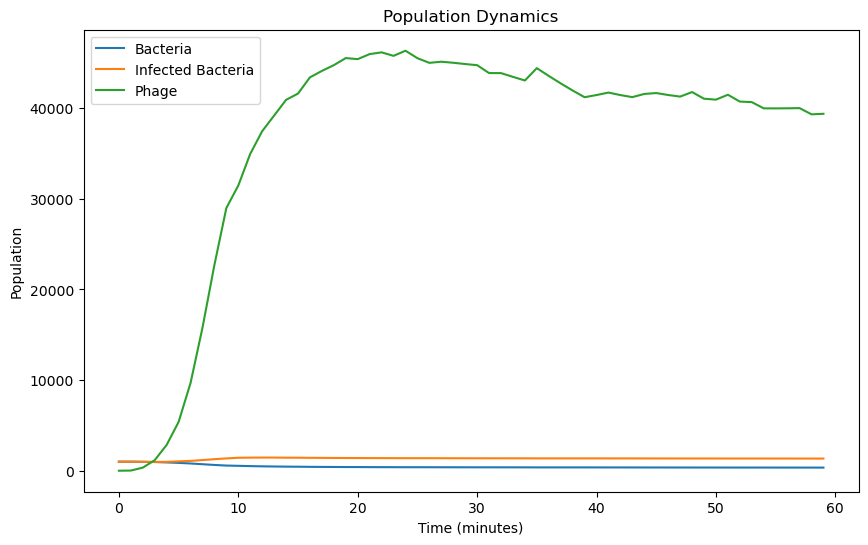

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(time2[:irecord2], Btimeseries2[:irecord2], label='Bacteria')
plt.plot(time2[:irecord2], Itimeseries2[:irecord2], label='Infected Bacteria')
plt.plot(time2[:irecord2], Ptimeseries2[:irecord2], label='Phage')
plt.xlabel('Time (minutes)')
plt.ylabel('Population')
plt.title('Population Dynamics')
plt.legend()
plt.show()

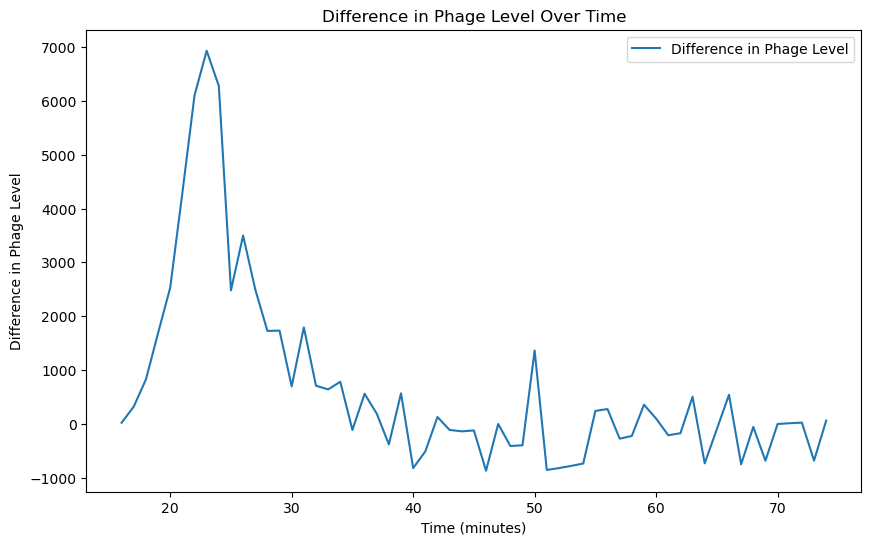

In [ ]:
P_diff = np.diff(Ptimeseries2[:irecord2])

# Create a new figure for the difference plot
plt.figure(figsize=(10, 6))

# Plot the difference in Phage levels
plt.plot(time2[1:irecord2]+15, P_diff, label='Difference in Phage Level')

# Label the axes
plt.xlabel('Time (minutes)')
plt.ylabel('Difference in Phage Level')

# Add a title to the plot
plt.title('Difference in Phage Level Over Time')

# Add a legend
plt.legend()

# Display the plot
plt.show()

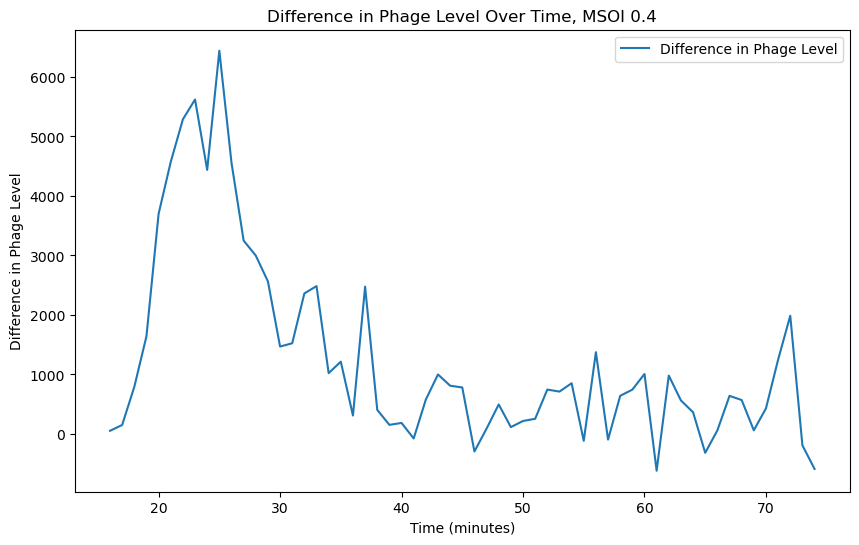

In [ ]:
P_diff = np.diff(Ptimeseries2[:irecord2])

# Create a new figure for the difference plot
plt.figure(figsize=(10, 6))

# Plot the difference in Phage levels
plt.plot(time2[1:irecord2]+15, P_diff, label='Difference in Phage Level')

# Label the axes
plt.xlabel('Time (minutes)')
plt.ylabel('Difference in Phage Level')

# Add a title to the plot
plt.title('Difference in Phage Level Over Time, MSOI 0.4')

# Add a legend
plt.legend()

# Display the plot
plt.show()